In [1]:
import sys
import os

# Add the parent directory of 'src' to sys.path
sys.path.append(os.path.abspath('../src'))

# Importação de bibliotecas
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from neural_network.utils import one_hot_encode, normalize_data, plot_single_confusion_matrix, plot_loss_and_accuracy_curve, display_final_metrics, plot_confusion_matrices_side_by_side, print_metrics_legend
from neural_network.losses import CategoricalCrossEntropyLoss
from neural_network.layers.dense_layer import DenseLayer
from neural_network.layers.dense_l2_layer import L2DenseLayer
from neural_network.layers.dropout_layer import DropoutLayer
from neural_network.optimizer import GradientDescent


In [2]:
# Carregar o arquivo CSV
data = pd.read_csv('../data/multiclass/online_gaming_behavior.csv')

# Exibir primeiras linhas do dataset
data.head()

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


In [3]:
# Selecionar colunas categóricas
categorical_columns = ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']

# Mapear cada categoria para um número
for column in categorical_columns:
    data[column] = data[column].astype('category').cat.codes

# Obter o número de classes para cada coluna categórica
num_classes = {column: data[column].nunique() for column in categorical_columns}

# Aplicar One-Hot Encoding
for column in categorical_columns:
    one_hot_encoded = one_hot_encode(data[column].values, num_classes[column])

    # Adicionar as colunas one-hot ao dataframe
    for i in range(num_classes[column]):
        data[f"{column}_{i}"] = one_hot_encoded[:, i]

    # Remover a coluna categórica original
    data = data.drop(column, axis=1)

# Exibir o dataset transformado
data.head()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_0,Gender_1,...,GameGenre_1,GameGenre_2,GameGenre_3,GameGenre_4,GameDifficulty_0,GameDifficulty_1,GameDifficulty_2,EngagementLevel_0,EngagementLevel_1,EngagementLevel_2
0,9000,43,16.271119,0,6,108,79,25,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,9001,29,5.525961,0,5,144,11,10,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,9002,22,8.223755,0,16,142,35,41,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,9003,35,5.265351,1,9,85,57,47,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,9004,33,15.531945,0,2,131,95,37,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
# Definir X (entrada) e y (saída)
cleared_data = data.drop(['PlayerID', 'EngagementLevel_0', 'EngagementLevel_1', 'EngagementLevel_2'], axis=1)
print(cleared_data.columns)

X = cleared_data.values
y = one_hot_encode(data[['EngagementLevel_0', 'EngagementLevel_1', 'EngagementLevel_2']].values.argmax(axis=1), 3)

# Normalizar os dados de entrada
X = normalize_data(X)

# Dividir em TREINO e TESTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir os dados de TREINO em TREINO e VALIDAÇÃO
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


Index(['Age', 'PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'Gender_0', 'Gender_1', 'Location_0', 'Location_1', 'Location_2',
       'Location_3', 'GameGenre_0', 'GameGenre_1', 'GameGenre_2',
       'GameGenre_3', 'GameGenre_4', 'GameDifficulty_0', 'GameDifficulty_1',
       'GameDifficulty_2'],
      dtype='object')


In [5]:
class NeuralNetwork:
    def __init__(self, layers, loss, optimizer):
        self.layers = layers
        self.loss = loss
        self.optimizer = optimizer
        
    def forward(self, X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, y_true, y_pred):
        grad = self.loss.backward(y_true, y_pred)
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self):
        for layer in self.layers:
            params = layer.get_parameters()
            if params:
                grads = layer.get_gradients()
                weights_updated, biases_updated = self.optimizer.update(
                    params['weights'], params['biases'],
                    grads['weights'], grads['biases']
                )
                layer.set_parameters({'weights': weights_updated, 'biases': biases_updated})

In [6]:
# Definir a arquitetura da rede neural
input_size = X_train.shape[1]
output_size = y_train.shape[1]

layers = [
    DenseLayer(input_size=input_size, output_size=256, activation='relu'),
    DropoutLayer(rate=0.05),
    DenseLayer(input_size=256, output_size=128, activation='relu'),
    DropoutLayer(rate=0.1),
    DenseLayer(input_size=128, output_size=128, activation='relu'),
    DropoutLayer(rate=0.2),
    DenseLayer(input_size=128, output_size=64, activation='relu'),
    DenseLayer(input_size=64, output_size=32, activation='relu'),
    DenseLayer(input_size=32, output_size=output_size, activation='softmax'),
]

loss = CategoricalCrossEntropyLoss()
optimizer = GradientDescent(learning_rate=0.015)

# Criar o modelo
model = NeuralNetwork(layers=layers, loss=loss, optimizer=optimizer)

In [7]:
# Configurações do tamanho do batch dinâmico
initial_batch_size = 1024
final_batch_size = 16384
batch_growth_rate = 32  # Taxa de aumento por época

epochs = 150
best_val_loss = float('inf')
early_stop_threshold = 5
no_improvement = 0

initial_learning_rate = optimizer.learning_rate
decay_rate = 0.001
decay_step = 10

loss_history = []
val_loss_history = []
accuracy_history = []
val_accuracy_history = []

# Timer
start_time = time.time()

# Treinar a rede neural
for epoch in range(epochs):
    # Ajustar Learning Rate
    if epoch % decay_step == 0 and epoch > 0:
        optimizer.learning_rate *= (1 - decay_rate)
        print(f"\nAdjusted Learning Rate: {optimizer.learning_rate:.6f}\n")
    
    # Atualizar o tamanho do batch
    batch_size = min(initial_batch_size + epoch * batch_growth_rate, final_batch_size)

    # Dividir os dados em batches
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    epoch_loss = 0
    epoch_accuracy = 0

    for batch in range(num_batches):
        # Criar batches
        start = batch * batch_size
        end = min((batch + 1) * batch_size, X_train.shape[0])
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Forward pass
        y_pred = model.forward(X_batch)

        # Calcular perdas e métricas
        batch_loss = loss.calculate(y_batch, y_pred)
        batch_accuracy = accuracy_score(y_batch.argmax(axis=1), y_pred.argmax(axis=1))

        # Atualizar perdas e acurácia por batch
        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy

        # Backward e update
        model.backward(y_batch, y_pred)
        model.update()

    # Média das métricas por época
    epoch_loss /= num_batches
    epoch_accuracy /= num_batches

    # Validação
    y_val_pred = model.forward(X_val)
    val_loss = loss.calculate(y_val, y_val_pred)
    val_accuracy = accuracy_score(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))

    # Guardar históricos
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Relatório a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1} - Batch Size: {batch_size}\n"
            f" Train -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}\n"
            f" Validation -> Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}"
        )

# Após o treinamento
elapsed_time = time.time() - start_time
print(f"__________________________________________________________")
print(f"\nElapsed Time: {elapsed_time:.2f}s")


Epoch 10 - Batch Size: 1312
 Train -> Loss: 1.0486, Accuracy: 0.4619
 Validation -> Loss: 1.0405, Accuracy: 0.4652

Adjusted Learning Rate: 0.014985

Epoch 20 - Batch Size: 1632
 Train -> Loss: 1.0063, Accuracy: 0.4876
 Validation -> Loss: 0.9991, Accuracy: 0.4911

Adjusted Learning Rate: 0.014970

Epoch 30 - Batch Size: 1952
 Train -> Loss: 0.9626, Accuracy: 0.5189
 Validation -> Loss: 0.9555, Accuracy: 0.5234

Adjusted Learning Rate: 0.014955

Epoch 40 - Batch Size: 2272
 Train -> Loss: 0.9193, Accuracy: 0.5503
 Validation -> Loss: 0.9115, Accuracy: 0.5546

Adjusted Learning Rate: 0.014940

Epoch 50 - Batch Size: 2592
 Train -> Loss: 0.8801, Accuracy: 0.5793
 Validation -> Loss: 0.8719, Accuracy: 0.5847

Adjusted Learning Rate: 0.014925

Epoch 60 - Batch Size: 2912
 Train -> Loss: 0.8486, Accuracy: 0.6078
 Validation -> Loss: 0.8386, Accuracy: 0.6078

Adjusted Learning Rate: 0.014910

Epoch 70 - Batch Size: 3232
 Train -> Loss: 0.8191, Accuracy: 0.6268
 Validation -> Loss: 0.8106, Ac

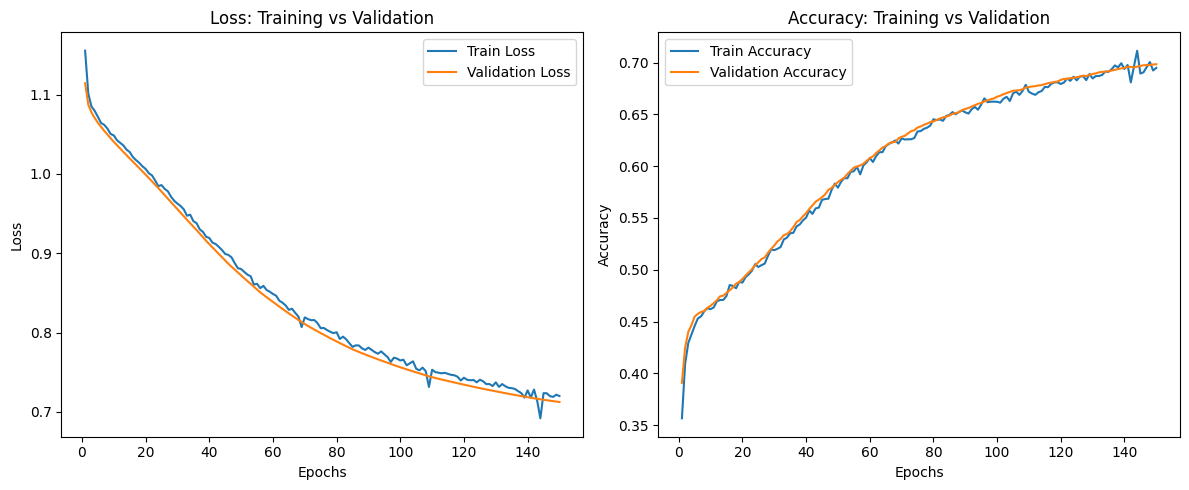

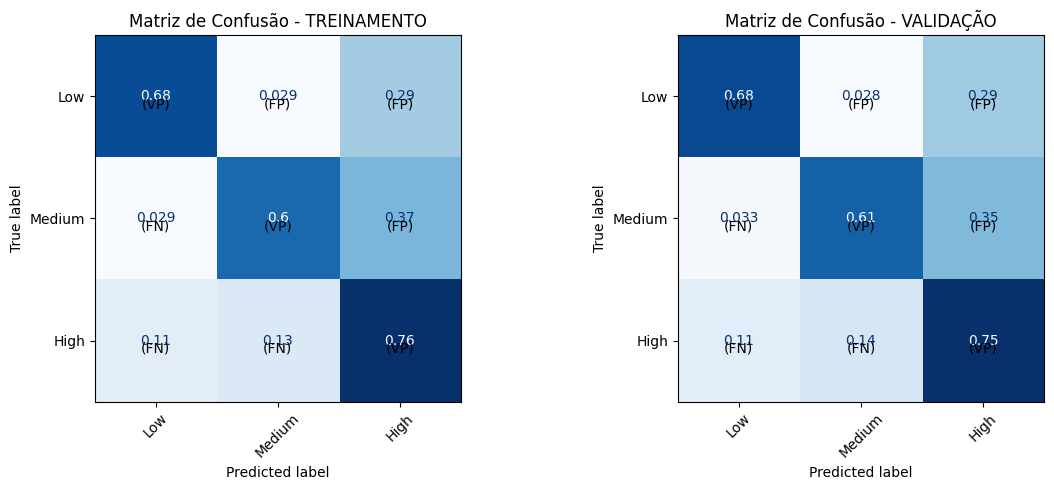


Métricas Finais:
              Metric    Value
             Camadas        9
       Learning Rate 0.014791
    Batch Size Final     5792
        Elapsed Time   83.38s
      Train Accuracy   0.6949
         Train Error   0.3051
          Train Loss   0.7199
 Validation Accuracy   0.6984
    Validation Error   0.3016
     Validation Loss   0.7124
Validation Precision   0.6993
   Validation Recall   0.6984
 Validation F1-Score   0.6975

    Legenda de Métricas:

    - Acurácia (Accuracy): Proporção de previsões corretas sobre o total de amostras.
      Fórmula: (VP + VN) / (VP + VN + FP + FN)
      
    - Precisão (Precision): Proporção de previsões corretas entre todas as previsões positivas feitas.
      Fórmula: VP / (VP + FP)
      Indica o quão confiável é o modelo quando prevê uma classe como positiva.

    - Sensibilidade (Recall): Proporção de positivos corretamente identificados pelo modelo.
      Fórmula: VP / (VP + FN)
      Mede a capacidade do modelo de encontrar todas as oc

In [8]:
# Relatórios finais
labels = ["Low", "Medium", "High"]

# Cálculo de métricas detalhadas para VALIDAÇÃO
val_true = y_val.argmax(axis=1)  # Rótulos verdadeiros
val_pred = y_val_pred.argmax(axis=1)  # Previsões

y_train_pred = model.forward(X_train).argmax(axis=1)  # Previsões para o treino
y_train_true = y_train.argmax(axis=1)                 # Rótulos verdadeiros para o treino

val_precision = precision_score(val_true, val_pred, average="weighted")
val_recall = recall_score(val_true, val_pred, average="weighted")
val_f1 = f1_score(val_true, val_pred, average="weighted")

# Gráficos Loss e Accuracy - TREINAMENTO/VALIDAÇÃO
plot_loss_and_accuracy_curve(loss_history, val_loss_history, accuracy_history, val_accuracy_history)

# Matriz de Confusão na TREINAMENTO/VALIDAÇÃO
plot_confusion_matrices_side_by_side(
    y_train_true=y_train_true,
    y_train_pred=y_train_pred,
    y_val_true=val_true,
    y_val_pred=val_pred,
    labels=labels
)

# Após o treinamento, chamar a função para exibir as métricas
display_final_metrics(
    epoch_accuracy=epoch_accuracy,
    epoch_loss=epoch_loss,
    val_accuracy=val_accuracy,
    val_loss=val_loss,
    val_precision=val_precision,
    val_recall=val_recall,
    val_f1=val_f1,
    model=model,
    optimizer=optimizer,
    batch_size=batch_size,
    elapsed_time=elapsed_time
)

print_metrics_legend()



Métricas Finais - TESTE:

Métricas Finais:
        Metric    Value
       Camadas        9
 Learning Rate 0.014791
  Elapsed Time    0.16s
 Test Accuracy   0.6998
    Test Error   0.3002
Test Precision   0.7014
   Test Recall   0.6998
 Test F1-Score   0.6984

    Legenda de Métricas:

    - Acurácia (Accuracy): Proporção de previsões corretas sobre o total de amostras.
      Fórmula: (VP + VN) / (VP + VN + FP + FN)
      
    - Precisão (Precision): Proporção de previsões corretas entre todas as previsões positivas feitas.
      Fórmula: VP / (VP + FP)
      Indica o quão confiável é o modelo quando prevê uma classe como positiva.

    - Sensibilidade (Recall): Proporção de positivos corretamente identificados pelo modelo.
      Fórmula: VP / (VP + FN)
      Mede a capacidade do modelo de encontrar todas as ocorrências da classe positiva.

    - F1-Score: Média harmônica entre Precisão e Sensibilidade.
      Fórmula: 2 * (Precision * Recall) / (Precision + Recall)
      Útil quando há

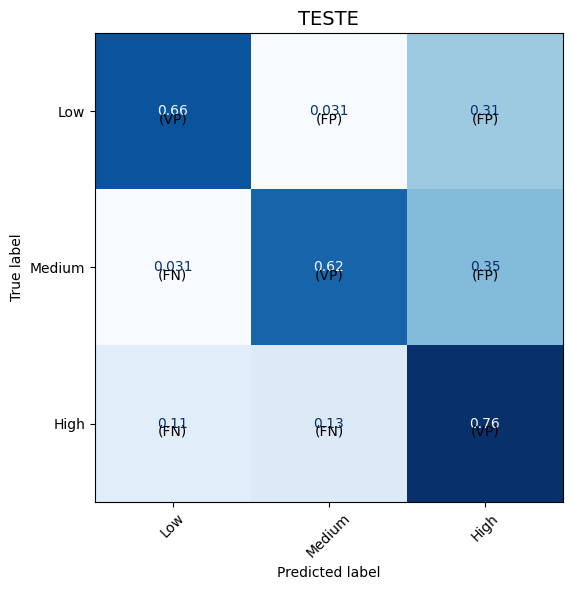

In [9]:
start_time = time.time()

# Fazer previsões no conjunto de teste
y_test_pred = model.forward(X_test).argmax(axis=1)
y_test_true = y_test.argmax(axis=1)

# Calcular métricas
test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred, average="weighted")
test_recall = recall_score(y_test_true, y_test_pred, average="weighted")
test_f1 = f1_score(y_test_true, y_test_pred, average="weighted")
elapsed_time = time.time() - start_time

# Relatório de métricas finais para teste
print(f"\nMétricas Finais - TESTE:")
display_final_metrics(
    test_accuracy=test_accuracy,
    test_precision=test_precision,
    test_recall=test_recall,
    test_f1=test_f1,
    model=model,
    optimizer=optimizer,
    elapsed_time=elapsed_time
)

# Matriz de confusão para teste
plot_single_confusion_matrix(y_test_true, y_test_pred, labels=labels, title="TESTE")
